<a href="https://colab.research.google.com/github/NShah19/QuantumProgramming/blob/main/DeutschJozsa/deutsch_jozsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Cirq & Import Libraries/Modules

In [1]:
!pip install git+https://github.com/quantumlib/Cirq.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3MB 5.6MB/s 


In [2]:
import cirq
import random
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Set Parameters (user input)

In [3]:
# Define input length
n_qubits = 10
case = 'balanced'
n_repititions = 10

## Build U_f and Assemble Circuit

In [4]:
# Assign qubits
def assign_qubits(n_qubits):
  input = [cirq.LineQubit(i) for i in range(n_qubits)]
  helper = cirq.LineQubit(n_qubits)
  return input, helper

In [5]:
# Adapted from https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html#4.3-The-Full-Algorithm-
def make_DJ_Uf(input, helper, case, n_qubits):
  """ Make Deutsch-Josza U_f """
  # Make a constant oracle
  if case == 'constant':
    output = random.randint(0,1)
    if output == 1:
      yield cirq.X(helper)
  
  # Make a balanced oracle
  if case == 'balanced':
    # Generate random number to decide which qubits to wrap in X-gates
    b = random.randint(0, (2**(n_qubits - 1)))
    # Convert number to bitstring with each bit corresponding to a qubit in the circuit
    b_list = np.array(list(format(b, 'b').zfill(n_qubits)), dtype=int)

    # Place first set of X-gates on qubits that have a 1 in the bitstring
    for qubit, val in enumerate(b_list):
      if val:
        yield cirq.X(input[qubit])
    
    # Apply CNOT gates to each qubit
    for qubit in range(n_qubits):
      yield cirq.CNOT(input[qubit], helper)

    # Place second set of X-gates on qubits that have a 1 in the bitstring
    for qubit, val in enumerate(b_list):
      if val:
        yield cirq.X(input[qubit])

In [6]:
def make_circuit(input, helper, Uf):
  """ Assemble quantum circuit for Deutsch-Josza/Berstein-Vazirani """
  # Initialize inputs in superposition
  circuit = cirq.Circuit()
  circuit.append(
      [
       cirq.X(helper), 
       cirq.H(helper), 
       cirq.H.on_each(*input)
      ], 
      strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
 
  # Append U_f
  circuit.append(Uf, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

  # Apply H on all input qubits and measure
  circuit.append(
      [
       cirq.H.on_each(*input),
       cirq.measure(*input, key='result')
      ],
      strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

  return circuit

In [7]:
# Helper function.
def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

In [16]:
def print_output(circuit, result):
  print('Case: ', case)
  print('Circuit:\n')
  print(circuit)
  # Look at the sampled bitstrings
  frequencies = result.histogram(key="result", fold_func=bitstring)
  print('Sampled results:\n{}'.format(frequencies))

  # Check if we actually found the value of a
  most_common_bitstring = frequencies.most_common(1)[0][0]
  print('Most common bitstring: {}'.format(most_common_bitstring))
  if int(most_common_bitstring) == 0:
    print('This function is constant!')
  else:
    print('This function is balanced!')

## Run Deutsch-Jozsa

In [17]:
def run_deutsch_jozsa(n_qubits, case, n_repititions):
  input, helper = assign_qubits(n_qubits)
  U_f = make_DJ_Uf(input, helper, case, n_qubits)
  circuit = make_circuit(input, helper, U_f)
  simulator = cirq.Simulator()
  result = simulator.run(circuit, repetitions=n_repititions)
  print_output(circuit, result)

In [18]:
run_deutsch_jozsa(n_qubits, case, n_repititions)

Case:  balanced
Circuit:

               ┌──┐
0: ────────H─────@────────────────────────────────────────────H───M('result')───
                 │                                                │
1: ────────H─────┼────@───────────────────────────────────────H───M─────────────
                 │    │                                           │
2: ────────H────X┼────┼───@───────────────────────────X───────H───M─────────────
                 │    │   │                                       │
3: ────────H─────┼────┼───┼───@───────────────────────────────H───M─────────────
                 │    │   │   │                                   │
4: ────────H────X┼────┼───┼───┼───@───────────────────X───────H───M─────────────
                 │    │   │   │   │                               │
5: ────────H────X┼────┼───┼───┼───┼───@───────────────X───────H───M─────────────
                 │    │   │   │   │   │                           │
6: ────────H─────┼────┼───┼───┼───┼───┼───@─────────────────

## **Simulation and Testing**

In [150]:
num_qubits = np.linspace(1, 25, 25, dtype=int)
cases = ['constant', 'balanced']
end_times = {}
for num in num_qubits:
  inputs, helper = assign_qubits(num)
  for case in cases:
    U_f = make_DJ_Uf(inputs, helper, case, num)
    circuit = make_circuit(inputs, helper, U_f)
    simulator = cirq.Simulator()
    start_time = time.time()
    result = simulator.run(circuit, repetitions=n_repititions)
    et = time.time() - start_time
    print_output(circuit, result)
    print("--- %s seconds ---" % (et))
    if num not in end_times:
      end_times[num] = [et]
    else:
      end_times[num].append(et)
print(end_times)   

Case:  constant
Circuit:

0: ───────H───────H───M('result')───

1: ───X───H───X─────────────────────
Sampled results:
Counter({'0': 10})
Most common bitstring: 0
This function is constant!
--- 0.0022325515747070312 seconds ---
Case:  balanced
Circuit:

0: ───────H───X───@───X───H───M('result')───
                  │
1: ───X───H───────X─────────────────────────
Sampled results:
Counter({'1': 10})
Most common bitstring: 1
This function is balanced!
--- 0.0027298927307128906 seconds ---
Case:  constant
Circuit:

0: ───────H───────H───M('result')───
                      │
1: ───────H───────H───M─────────────

2: ───X───H───X─────────────────────
Sampled results:
Counter({'00': 10})
Most common bitstring: 00
This function is constant!
--- 0.0030035972595214844 seconds ---
Case:  balanced
Circuit:

              ┌──┐
0: ───────H─────@────────────H───M('result')───
                │                │
1: ───────H────X┼────@───X───H───M─────────────
                │    │
2: ───X───H─────X────X

[(1, [0.0022325515747070312, 0.0027298927307128906]), (2, [0.0030035972595214844, 0.004076719284057617]), (3, [0.0033791065216064453, 0.005393028259277344]), (4, [0.004045724868774414, 0.007889509201049805]), (5, [0.0053195953369140625, 0.007468223571777344]), (6, [0.007781267166137695, 0.009173870086669922]), (7, [0.008849859237670898, 0.012100696563720703]), (8, [0.013936281204223633, 0.02011704444885254]), (9, [0.020714998245239258, 0.016946792602539062]), (10, [0.017884016036987305, 0.02282094955444336]), (11, [0.04173564910888672, 0.031374216079711914]), (12, [0.056784629821777344, 0.05573225021362305]), (13, [0.09574675559997559, 0.1069498062133789]), (14, [0.17782807350158691, 0.2045271396636963]), (15, [0.3787117004394531, 0.37801384925842285]), (16, [0.7457029819488525, 0.755995512008667]), (17, [1.525618076324463, 1.5168938636779785]), (18, [3.056820869445801, 3.0854616165161133]), (19, [6.274792194366455, 6.258165597915649]), (20, [12.926063060760498, 13.169459342956543]), (

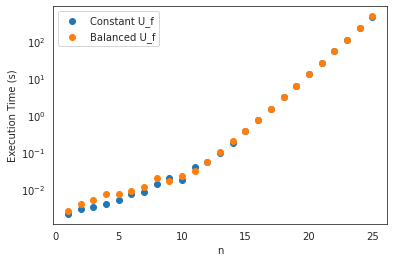

In [163]:
lists = sorted(end_times.items())
print(lists)
x = [val[0] for val in lists]
y_const = [val[1][0] for val in lists]
y_bal = [val[1][1] for val in lists]

sns.set_style('white')
plt.xlabel('n')
plt.ylabel('Execution Time (s)')
plt.scatter(x, y_const, label='Constant U_f')
plt.scatter(x, y_bal, label='Balanced U_f')
plt.yscale('log')
plt.legend()
plt.show()